In [40]:
import requests
import bz2
import json
from xml.etree.cElementTree import iterparse
import time

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline  

In [41]:
requests.delete('http://localhost:9200/wiki-test')

<Response [200]>

## Create mappings

First trial, I'm just creating a simple mapping with 2 string fields.

In [42]:
print requests.put('http://localhost:9200/wiki-test', data="""
{
    "settings": {
        "number_of_shards": 1 
    },
    "mappings": {
        "page": {
            "properties": {
                "title": {
                    "type": "string"
                },
                "text": {
                    "type": "string"
                }
            }
        }
    }
}
""")

<Response [200]>


## Load data

I'm going to use the Requests streaming API to stream the latest, parse the XML and load in Elasticsearch. It took about 1.3 hours (4762.685485363007 seconds) to index the entire 12G dataset. [Script used here](https://github.com/lextoumbourou/study-notes/blob/master/misc/elasticsearch/phrase-query-tests/wikimedia_loader.py).

## Define test function

In [ ]:
def run_test(query, time_in_secs=60):
    """
    Start by clearing the cache. Then, run query until we hit or exceed ``time_in_secs``.
    
    Displays a plot of query time and returns some stats about them.
    """
    results = []

    requests.post('http://localhost:9200/wiki-test/_cache/clear')
    
    time_start = time.time()

    while (time.time() - time_start) < time_in_secs:
        r = requests.post("http://localhost:9200/wiki-test/_search", data=query)
        if r.status_code != 200:
            print "That failed:"
            print r.json()
            return
        
        results.append(r.json()['took'])
    
    results = sorted(results)
    
    plt.ylabel('Time taken')
    plt.plot(results)
    plt.show()

    print "Median: {0}, Max: {1}, Min: {2}".format(np.median(np.array(results)), max(results), min(results))

## Test #1: standard phrase query

Params:

    * Data size: 10

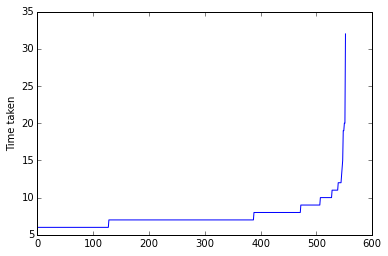

Median: 7.0, Max: 32, Min: 6


In [31]:
run_test("""
    {
        "query": {
            "match_phrase": {
                "text": "running the risk"
            }
        },
        "size": 20
    }
    """, 10)

## Test #2: Term query (min should match at 100%)

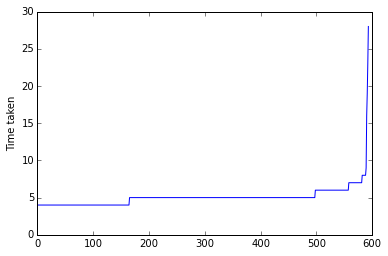

Median: 5.0, Max: 28, Min: 4


In [32]:
run_test("""
    {
        "query": {
            "match": {
                "text": {
                    "query": "running the risk",
                    "minimum_should_match": "100%"
                }
            }
        },
        "size": 20
    }
    """, 10)

## Test #3: ask for less results

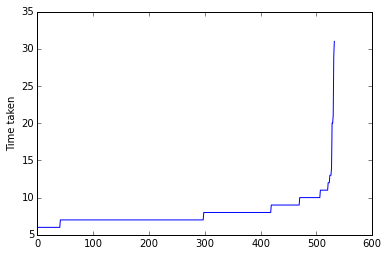

Median: 7.0, Max: 31, Min: 6


In [33]:
run_test("""
    {
        "query": {
            "match_phrase": {
                "text": "running the risk"
            }
        },
        "size": 8
    }
    """, 10)

## Test #4: rescore request

A [rescore request](https://www.elastic.co/guide/en/elasticsearch/reference/1.7/search-request-rescore.html) allows you to run a cheap algorithm and return the top docs from that, then perform the more expensive query against the limited selection of docs.

In [ ]:
run_test("""
    {
        "query": {
            "match": {
                "text": "running the risk"
            }
        },
        "rescore": {
           "window_size": 50,
           "query": {
               "rescore_query" : {
                   "match_phrase": {
                       "text": {
                           "query": "running the risk",
                           "slop": 2
                       }
                   }
               },
               "query_weight" : 0.7,
               "rescore_query_weight" : 1.2
            }
         }
    }
    """, 10)

## Test #5: use shingles

Sources:

https://www.elastic.co/blog/searching-with-shingles
https://www.elastic.co/guide/en/elasticsearch/guide/master/shingles.html

"Shingles" in Elasticsearch, let's you tokenize words in the index, effectively letting you perform term queries that respect positional information.

What does that mean? Well, if you look at the sentence "we are running the risk", a shingles tokenisation process would end up storing the following terms in the index:

* ``we are``
* ``are running``
* ``running the``
* ``the risk``

Shingles are created at index time, one [commonly recommended approach](https://www.elastic.co/guide/en/elasticsearch/guide/master/shingles.html#_producing_shingles) is to create a separate field for the bigrams and one for unigrams, which can be achieved with a multifield.

To use them, you must first create an analyzer that uses the token filter.

In [ ]:
requests.delete('http://localhost:9200/wiki-test-shingles')
print requests.put('http://localhost:9200/wiki-test-shingles', data="""
{
    "settings": {
        "number_of_shards": 1 
        "analysis": {
            "filter": {
                "shingle_filter": {
                    "type": "shingle",
                    "min_shingle_size": 2,
                    "max_shingle_size": 2,
                    "output_unigrams": false
                }
            },
            "analyzer": {
                "shingle_analyzer": {
                    "type":             "custom",
                    "tokenizer":        "standard",
                    "filter": [
                        "lowercase",
                        "shingle_filter" 
                    ]
                }
            }
        }
    }
    "mappings": {
        "page": {
            "properties": {
                "title": {
                    "type": "string"
                },
                "text": {
                    "type": "string",
                    "fields": {
                        "shingles": {
                            "type":     "string",
                            "analyzer": "shingle_analyzer"
                        }
                    }
                }
            }
        }
    }
}
""")

You can adjust the Shingle size based on your needs, however, note that this can dramatically increase your index size. In my tests, adding a bigram shingle field increased my index size to roughly x. A trigram shingle field increased it to x.

With Shingles field up and running, you could now perform a bool query, boosting results which match the Shingles as well as the unigrams.

In [ ]:
run_test("""
    {
        "query": {
            "bool": {
                "must": {
                    "match": {
                        "text": {
                            "query": "running the risk",
                        }
                    }
                },
                "should": {
                    "match": {
                        "text.shingles": {
                            "query": "running the risk"
                        }
                    }
                }
            }
        },
        "size": 20
    }
    """, 10)

## Bonus: general stuff

With that out the way, the standard Elasticsearch stuff apply for checking query performance.

* Filter first, with cachable filters.

  Can you limit the size of the docs queried by performing a filter first? Particularly one that's cachable.
      
  You should check your heap size, field data size (doc_values yo) and filter evictions and other stuff. [This article](http://radar.oreilly.com/2015/04/10-elasticsearch-metrics-to-watch.html) is quite helpful for looking at stuff to monitor.
 
      
* Does Lucene have sufficient resources?
    
  The general recommendation is to give 50% of your RAM to heap (but never more than 32GB) and 50% to Lucene. You should ensure that the OS if performing plenty of caching as disk reads can slow down queries significantly.
      
  Also, Phrase Queries can be slightly CPU intensive, as Lucene needs to calculate term position information as well as just looking it up in the index (not a problem if you have decided to go with Shingles), so ensuring you have adequate capacity there.